In [1]:
#
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook


#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpd
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
from nepal_figs import *
import nepal_figs
import optimizers
#
import random
import geopy
#
#colors_ =  mpl.rcParams['axes.color_cycle']
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']		# make sure these are correct...
tzutc = pytz.timezone('UTC')
#

failed while loading urllib and/or urllib. maybe python 3.x?


data handle fetched...
 no file.
cat_len:  101
len new catalog:  101
begin globalETAS.__init()__
ETAS over etas_cat_range/xyz_range:  ([0, 101], None)
make_etas():
begin make_etas_rtree()
len(local_lattice_dict):  400
Indices initiated. begin ETAS ::  [0, 101]
finished calculateing ETAS (rtree). wrap up in recarray and return.
ETAS complete.
*********************
*******************
evecs:  [  7.82330910e-02   1.38777878e-17] [[ 0.86615809 -0.4997701 ]
 [ 0.4997701   0.86615809]]
xprime:  [ 0.86615809 -0.4997701 ] [ 0.4997701   0.86615809]
x_prime dot y_prime:  0.0 0.0 [ 0.43307905 -0.24988505] [ 0.24988505  0.43307905] 0.0


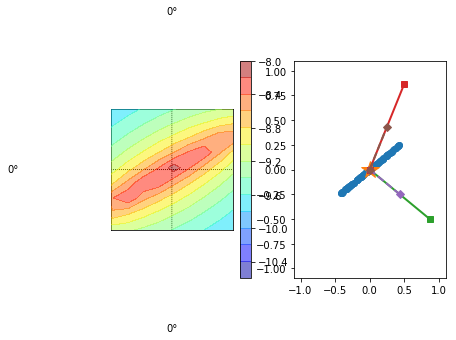

In [2]:
theta = (1./6.)*3.14
#
#ut = globalETAS.elliptical_transform_test(theta = 3.15/4., x0=0., y0=0., n_quakes=100, m=6.0, max_ratio=2.0, fignum=0)
#aa=globalETAS.elliptical_transform_test(theta=theta, m=7., dm=3.)
aa=globalETAS.elliptical_transform_test(theta=theta, m=7.)
#print('evecs: ', aa.catalog[-1]['e_vecs'])

In [3]:
# TODO: wtf? check out:
#> globalETAS.elliptical_transform_test(theta = 0., x0=0., y0=0., n_quakes=100, m=6.0, max_ratio=2.0, fignum=0):
# this seems to work really well. it should be pretty much exactly the test we're writing here.

class orientation_test(object):
    
    def __init__(self, N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., dt=2.,
                     t0=dtm.datetime(2016,1,1, tzinfo=tzutc)):
        #
        # TODO:
        # something odd going on so that the transformation is not fitting correctly, but we don't see this
        # in the globalETAS.py unit test, and i don't think we see it in actualy ETAS instances... but
        # we should sort it out.
        # the globalETAS script seems to get the right pca transform; let's figure out what we're doing wrong
        # and confirm that it's not happing in real life.
        #
        L_r = 10.**(.5*m0 - 1.76)
        L = 3.5*L_r
        #print('**L,L_r = ', L, L_r)
        d_LL = L/111.1
        y_scatter = 0.
        #
        R = random.Random()
        r_factor=.2
        km2_ll = 1./111.
        m = m0-dm
        m_ms = m0
        #
        #d_lat = km2_ll*L*math.sin(theta)/N_ev
        #d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
        dt = dtm.timedelta(days=dt)
        dy0=0.
        #dy0=.5*L
        LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
        LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
        #
        print('LLs: ', LLs[0:5])
        #print('theta: ', theta)
        M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]).T
        #print('M_r: ', M_r)
        LLs = numpy.dot(LLs, M_r)
        #
        cat = []
        #for j in range(N_ev):
        #    cat += [[t0+dt*j, lon0+j*d_lon*(1.0+R.random()*r_factor), lat0+j*d_lat*(1.0+R.random()*r_factor), m-3., mpd.date2num(t0+dt*j) ]]
        for j, (lon,lat) in enumerate(LLs):
            cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
        #
        tms = cat[int(.5*len(cat))][0]
        #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
        #        mpd.date2num(cat[-1][0]+dt) ]]
        cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
                mpd.date2num(tms+.5*dt) ]]
        #
        cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])
        cat_original = cat.copy()
        #cat = gep.make_ETAS_catalog_mpp(cat)
        cat = gep.make_ETAS_catalog(cat, fit_factor=2.0)
        #
        # get the pca transform (for debugging):
        xy = [cat['lon'], cat['lat']]
        cov = numpy.cov(xy)
        print('evals/vecs: ', numpy.linalg.eig(cov))
        #
        # get default lat/lon ranges:
        delta_lats = max(cat['lat']-min(cat['lat']))
        delta_lons = max(cat['lon']-min(cat['lon']))
        delta_lls = max(delta_lats, delta_lons)*.5
        lat_0 = numpy.mean(cat['lat'])
        lon_0 = numpy.mean(cat['lon'])
        my_lats = [lat_0-delta_lls, lat_0+delta_lls]
        my_lons = [lon_0-delta_lls, lon_0+delta_lls]
        #etas = gep.ETAS_mpp(catalog=cat, lons=sorted(cat['lon'])[0::len(cat)-1],  lats=sorted(cat['lat'])[0::len(cat)-1]),
        etas = gep.ETAS_mpp(catalog=cat, lats=my_lats, lons=my_lons )
        #
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.plot(cat['lon'], cat['lat'], marker='o', ls='')
        plt.plot(cat['lon'][-1], cat['lat'][-1], marker='*', color='r', ls='', ms=16)
        #plt.plot(cat2['lon'], cat2['lat']+.25, marker='o', ls='', color='r')'
        for x,y in itertools.product(sorted(cat['lon'])[0::len(cat)-1], sorted(cat['lat'])[0::len(cat)-1]):
            plt.plot([x],[y], '.')
        #
        #return etas
        self.__dict__.update(locals())

   

LLs:  [[-0.86561344  0.        ]
 [ 0.86561344  0.        ]
 [-0.03640317  0.        ]
 [-0.11214379  0.        ]
 [ 0.11312106  0.        ]]
evals/vecs:  (array([  4.05420186e-02,  -1.73472348e-18]), array([[ 0.86615809, -0.4997701 ],
       [ 0.4997701 ,  0.86615809]]))
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 103], None)
make_etas():
etas_mpp worker xyz_range:  [0, 75]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 103], [0, 75])
etas_mpp worker xyz_range:  [75, 150]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) 

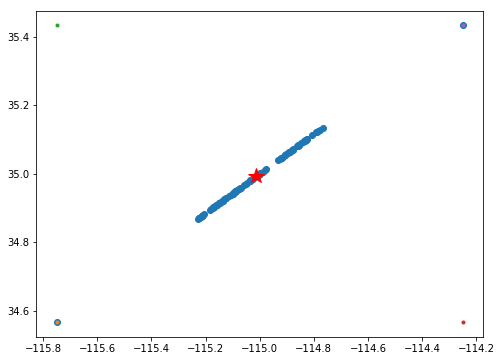

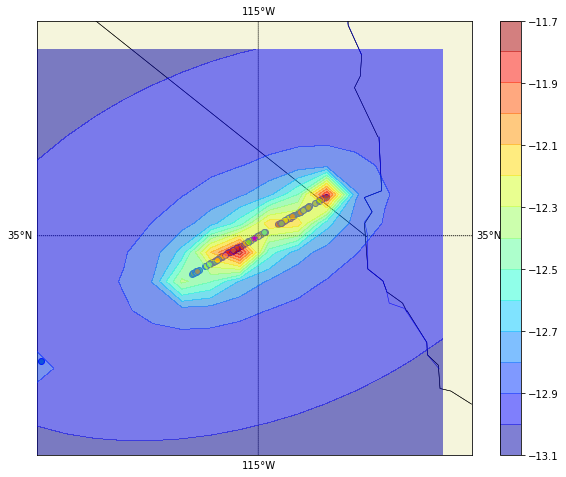

In [4]:
#etas = orientation_test(N_ev=50, theta=0.*3.14/4.)
#for theta in [3.14/6, 3.14/4., 3.14/2., .75*3.14]:
for theta in [theta]:
    etas = None
    etas = orientation_test(N_ev=100, theta=theta, m0=7., dm=4.)
    #
    plt.figure(figsize=(10,8))
    plt.clf()
    ax=plt.gca()
    etas.etas.make_etas_contour_map(ax=ax)
    ms=etas.etas.catalog[0]
    for ev in etas.etas.catalog:
        #
        if ev['mag']>ms['mag']: ms=ev
        x,y = ev['lon'], ev['lat']
        etas.etas.cm.scatter(x,y, marker='o', edgecolors='b')
    print(etas.etas.catalog[-1])
    etas.etas.cm.scatter(ms['lon'], ms['lat'], marker='*', s=28, c='m', zorder=11)
print('finished...')

max_mag = max(etas.etas.catalog['mag'])


### Elliptical transform test:
 Are we doingthe elliptical transform correctly? This is actually very difficut to know for sure when we have other earthquakes in the sequence, so just grab one; make a catalog, make an ETAS, and force its rotation. If the transforms for the real(ish) map are wrong, but this works properly, the problem is with the orientation fitting.

In [5]:
max_mag=etas.etas.catalog['mag'][0]
rw = etas.etas.catalog[0]
for rw in etas.etas.catalog:
    if rw['mag']>=max_mag:
        new_cat = numpy.array([rw], dtype=etas.etas.catalog.dtype)
        break

print('new_cat: ', new_cat)
#
for rw in new_cat: print('rw: ', rw)
print('mag: ', new_cat['mag'])

n_events=150
#theta = -3.14/4.
#
# theta is from where? if we put a bunch of dots (earthquakes) in a line on the x axis, this
# corresponds to 0 degrees/radians.
# TODO: in later unit tests, make some events; plot them; get their PCA, then do the single event
# ETAS contours over the top... for now, we can say that the elliptical transform is working.
R=random.Random()
L = .01*3.0*10**(.5*rw['mag']-1.76)
L = 2.5
#
d_lat=2.5
d_lon=2.5

new_cat:  [ (datetime.datetime(2016, 1, 1, 0, 0), -115.7497580856636, 34.567392283406654, 3.0, 735964.0, 0.5495408738576245, 0.051682895650509875, 27.819964832922334, 0.16595869074375613, 0.0027285955130155206, 57.069764961619526, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 1.0)]
rw:  (datetime.datetime(2016, 1, 1, 0, 0), -115.7497580856636, 34.567392283406654, 3.0, 735964.0, 0.5495408738576245, 0.051682895650509875, 27.819964832922334, 0.16595869074375613, 0.0027285955130155206, 57.069764961619526, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 1.0)
mag:  [ 3.]


calcing etas on new_cat (1)
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 833]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 833])
etas_mpp worker xyz_range:  [833, 1666]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [833, 1666])
etas_mpp worker xyz_range:  [1666, 2500]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog

/home/myoder/Dropbox/Research/globalETAS/globalETAS.py:361: RuntimeWarning: divide by zero encountered in log10
  if Z is None: Z = numpy.log10(self.lattice_sites)


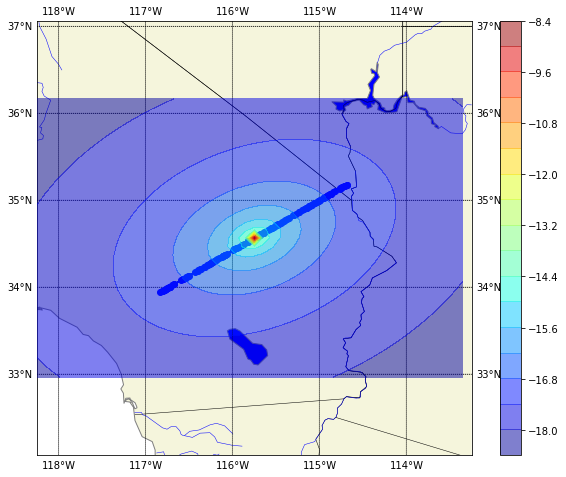

In [6]:
# make an earthquake; force it's orientation (eigenvalues) along a strike(ish) of theta. to ETAS contours
# around that event, then plot a bunch of dots (pseudo events) along that vector.
# TODO: make this better. make a catalog of all these events; fetch the eigenvectors from the large event (from fitting
# the small events).
#new_cat['mag']=6.
new_cat['e_vals'] = numpy.array([2.0, 1.0])
new_cat['e_vecs'] = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
print('calcing etas on new_cat ({})'.format(len(new_cat)))
new_etas = gep.ETAS_mpp(catalog=new_cat, lats=[rw['lat']-d_lat, rw['lat']+d_lat], lons=[rw['lon']-d_lon, rw['lon']+d_lon] )

xy = numpy.array([[L*(R.random()-.5), 0.] for j in range(n_events)])
xy_prime = numpy.dot(xy, new_cat[0].e_vecs.T)
xy_prime += numpy.array([new_cat[0]['lon'], new_cat[0]['lat']])
pca = gep.get_pca(xy_prime)
#
plt.figure(figsize=(10,8))
plt.clf()
ax=plt.gca()
new_etas.make_etas_contour_map(ax=ax)
#new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
new_etas.cm.plot(*zip(*xy_prime), marker='o', color='b', zorder=7)


# now, let's make a bogus catalog from xy_prime and see if we can't get the catalog maker to properly fit it.
#
t0 = dtm.datetime(2016,1,1, tzinfo=pytz.utc)
dt=dtm.timedelta(hours=1.)
m0 = 3.0
dm = 3.0
#
new_cat = [[t0+j*dt, y, x, m0, mpd.date2num(t0+j*dt)] for j, (x,y) in enumerate(xy_prime)]
#
tf_ms = numpy.mean([rw[-1] for rw in new_cat])
x_ms = numpy.mean([rw[2] for rw in new_cat])
y_ms = numpy.mean([rw[1] for rw in new_cat])

new_cat += [[mpd.num2date(tf_ms), y_ms, x_ms, m0+dm, tf_ms]]

new_cat = numpy.core.records.fromarrays(zip(*new_cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lat', '>f8'), ('lon', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])

In [7]:
etas_cat_test = gep.make_ETAS_catalog(new_cat, fit_factor=2.)

#print(etas_cat_test)
#plt.figure()
#plt.clf()
#plt.plot(*zip(*xy_prime), 'o')

In [8]:
print(len(new_cat[0]), len(new_cat.dtype))

j_max, rw_max = 0,etas_cat_test[0]
for j,rw in enumerate(etas_cat_test):
    if rw['mag']>rw_max['mag']:
        j_max=j
        rw_max=rw
#
print('dtypes: ', etas_cat_test.dtype)
rw_max['e_vecs']

5 5
dtypes:  (numpy.record, [('event_date', '<M8[us]'), ('lat', '>f8'), ('lon', '>f8'), ('mag', '>f8'), ('event_date_float', '>f8'), ('L_r', '<f8'), ('r_0', '<f8'), ('chi', '<f8'), ('dt_r', '<f8'), ('t_0', '<f8'), ('tau', '<f8'), ('dmstar', '<f8'), ('p', '<f8'), ('q', '<f8'), ('e_vals', '>f8', (2,)), ('e_vecs', '>f8', (2, 2)), ('N_eig_cat', '>f8')])


array([[ 0.86615809, -0.4997701 ],
       [ 0.4997701 ,  0.86615809]])

In [9]:
for rw in etas_cat_test:
    if rw['mag']>3.0: print(rw)

(datetime.datetime(2016, 1, 4, 2, 30), 34.56605003208383, -115.75208435896775, 6.0, 735967.1041666666, 17.378008287493753, 84.65108954313368, 0.0006874066346783245, 5.248074602497728, 8.62857663444466, 0.02549212761626736, 1.0, 1.1, 1.5, array([  6.82923373e-02,  -6.93889390e-18]), array([[ 0.86615809, -0.4997701 ],
       [ 0.4997701 ,  0.86615809]]), 55.0)


In [10]:
print('theta: ', theta, theta/3.141)

theta:  0.5233333333333333 0.16661360500902048


### more transform tests:
- use a toy catalog
- generate a globalETAS catalog; it should fit all events, namely the big one.
- now, grab just that event and do a single-event etas.
- compare to orientation of events.

etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 2.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': ['1990-1-1', None], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 300])
etas_mpp worker xyz_range:  [300, 600]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3

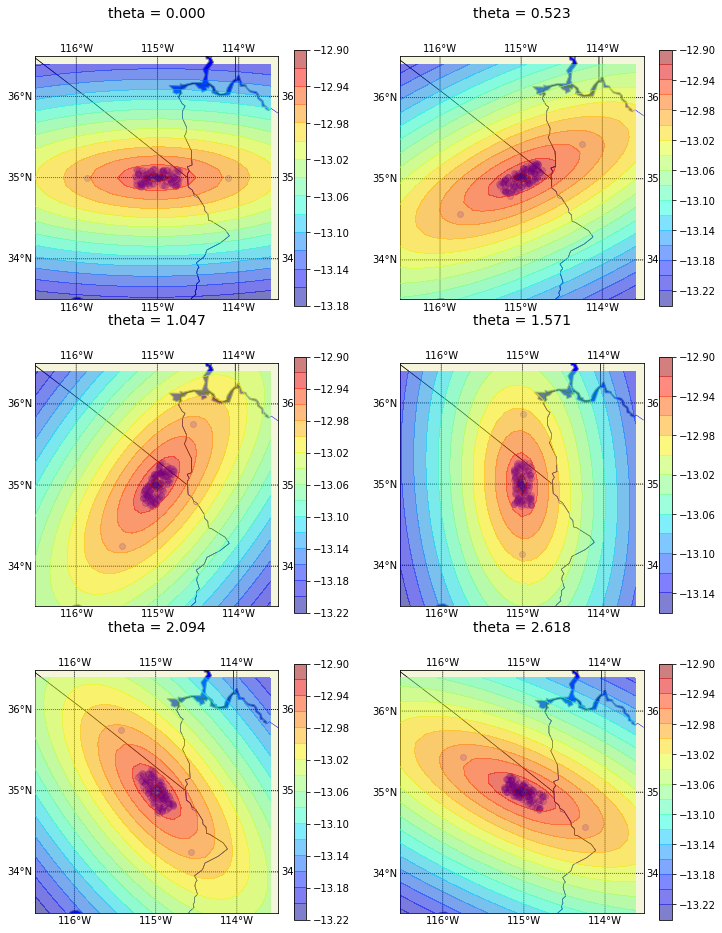

In [11]:
# make a toy catalog:
#N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., delta_t=2., t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
N_ev=120
#theta=(1./6.)*3.14
m0=7.
dm=3.
lat0=35.
lon0=-115.
delta_t=2.
t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
#
L_r = 10.**(.5*m0 - 1.76)
L = 3.5*L_r
#print('**L,L_r = ', L, L_r)
d_LL = L/111.1
y_scatter = 0.45
ab_ratio_expon=.5
#
R = random.Random()
r_factor=.2
km2_ll = 1./111.
m = m0-dm
m_ms = m0
#
#d_lat = km2_ll*L*math.sin(theta)/N_ev
#d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
dt = dtm.timedelta(days=delta_t)
dy0=0.
#

fg=plt.figure(figsize=(12,16))
plt.clf()
#ax=plt.gca()
n_rw=3
n_cl=2
    
for k,theta in enumerate([(x/6.)*3.141 for x in range(6)]):
    #
    LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
    LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
    #
    #print('LLs: ', LLs[0:5])
    #print('theta: ', theta)
    M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]).T
    #print('M_r: ', M_r)
    LLs = numpy.dot(LLs, M_r)
    #
    cat = []
    #for j in range(N_ev):
    #    cat += [[t0+dt*j, lon0+j*d_lon*(1.0+R.random()*r_factor), lat0+j*d_lat*(1.0+R.random()*r_factor), m-3., mpd.date2num(t0+dt*j) ]]
    for j, (lon,lat) in enumerate(LLs):
        cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
    #
    tms = cat[int(.5*len(cat))][0]
    #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
    #        mpd.date2num(cat[-1][0]+dt) ]]
    # add a mainshock:
    cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
            mpd.date2num(tms+.5*dt) ]]
    #
    #
    cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                    ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                                   ('event_date_float', '>f8')])
    cat_original = cat.copy()
    #
    ######################################
    ######################################
    #

    #print(etas.cat_original[0:3])
    #print(max(etas.cat_original['mag'])) 
    #
    gep_cat = cat_original.copy()
    # add a mainshock (assign a large magnidute to the middle event):
    #gep_cat[int(len(gep_cat)/2)]['mag'] +=3.
    gep_cat = gep.make_ETAS_catalog_mpp(incat=gep_cat, fit_factor=2.5)

    #print('\nmainshock: {}\n'.format([rw for rw in gep_cat if rw['mag']==max(gep_cat['mag'])]))
    #print('ab: ', numpy.sqrt())

    #
    # get just the mainshock:
    max_mag = max(gep_cat['mag'])
    rw = gep_cat[0]
    for rw in gep_cat:
        if rw['mag']>=max_mag:
            ms_cat = numpy.array([rw], dtype=etas.etas.catalog.dtype)
            mainshock = rw
            break


    d_lat=1.5
    d_lon=1.5
    mylats = [rw['lat']-d_lat, rw['lat']+d_lat]
    mylons = [rw['lon']-d_lon, rw['lon']+d_lon] 
    ms_etas = gep.ETAS_mpp(catalog=ms_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon, ab_ratio_max=2.)

    #
    ax=plt.subplot('{}{}{}'.format(n_rw, n_cl, k+1))
    ms_etas.make_etas_contour_map(ax=ax, lats_map=mylats, lons_map=mylons)
    #new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
    #new_etas.cm.plot(gep_cat['lon'], gep_cat['lat'], marker='o', color='b', zorder=7, latlon=True)

    #plt.figure()
    ax.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.2)
    ax.set_title('theta = {:.3f}\n\n'.format(theta), size=14)



### Orientation Test, with all events included:
("Full" ETAS)

etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 2.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f02847f1390>), datetime.datetime(2018, 11, 25, 20, 42, 53, 505220, tzinfo=<UTC>)], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 123], None)
make_etas():
etas_mpp worker xyz_range:  [0, 300]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-27 20:42:28.946694+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 123], [0, 300])
etas_mpp worker xyz_range:  [300,

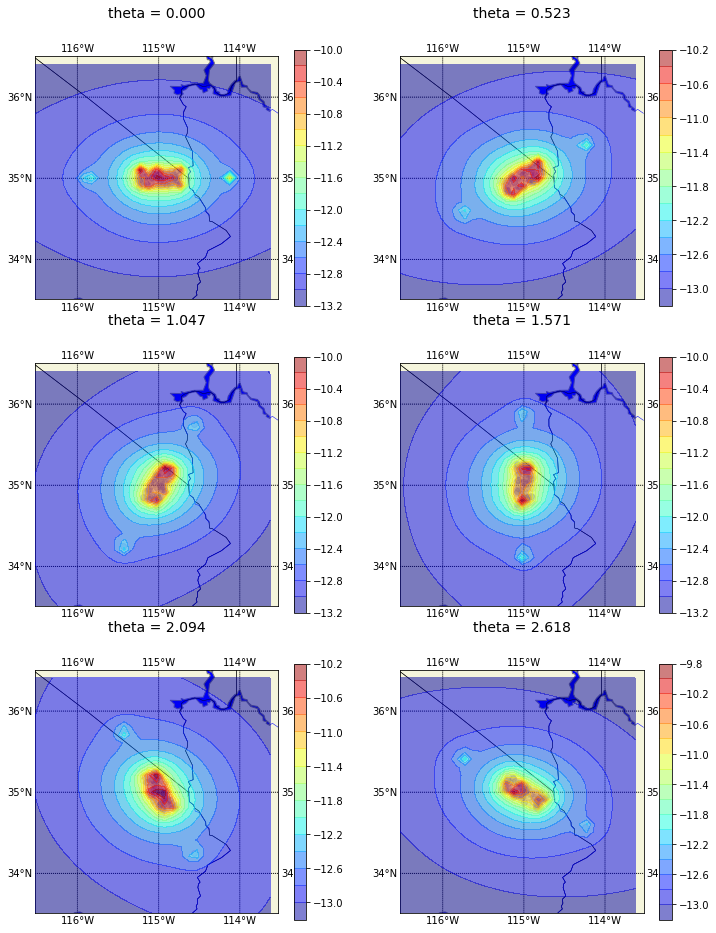

In [12]:
# make a toy catalog:
#N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., delta_t=2., t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
N_ev=120
#theta=(1./6.)*3.14
m0=7.
dm=3.
lat0=35.
lon0=-115.
delta_t=2.
t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
#
L_r = 10.**(.5*m0 - 1.76)
L = 3.5*L_r
#print('**L,L_r = ', L, L_r)
d_LL = L/111.1
y_scatter = 0.45
ab_ratio_expon=.5
#
R = random.Random()
r_factor=.2
km2_ll = 1./111.
m = m0-dm
m_ms = m0
#
#d_lat = km2_ll*L*math.sin(theta)/N_ev
#d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
dt = dtm.timedelta(days=delta_t)
dy0=0.
#

fg=plt.figure(figsize=(12,16))
plt.clf()
#ax=plt.gca()
n_rw=3
n_cl=2
    
for k,theta in enumerate([(x/6.)*3.141 for x in range(6)]):
    #
    LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
    LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
    #
    #print('LLs: ', LLs[0:5])
    #print('theta: ', theta)
    M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]).T
    #print('M_r: ', M_r)
    LLs = numpy.dot(LLs, M_r)
    #
    cat = []
    #for j in range(N_ev):
    #    cat += [[t0+dt*j, lon0+j*d_lon*(1.0+R.random()*r_factor), lat0+j*d_lat*(1.0+R.random()*r_factor), m-3., mpd.date2num(t0+dt*j) ]]
    for j, (lon,lat) in enumerate(LLs):
        cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
    #
    tms = cat[int(.5*len(cat))][0]
    #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
    #        mpd.date2num(cat[-1][0]+dt) ]]
    # add a mainshock:
    cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
            mpd.date2num(tms+.5*dt) ]]
    #
    #
    cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                    ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                                   ('event_date_float', '>f8')])
    cat_original = cat.copy()
    #
    ######################################
    ######################################
    #
    #print(etas.cat_original[0:3])
    #print(max(etas.cat_original['mag'])) 
    #
    gep_cat = cat_original.copy()
    # add a mainshock (assign a large magnidute to the middle event):
    #gep_cat[int(len(gep_cat)/2)]['mag'] +=3.
    gep_cat = gep.make_ETAS_catalog_mpp(incat=gep_cat, fit_factor=2.5)

    #print('\nmainshock: {}\n'.format([rw for rw in gep_cat if rw['mag']==max(gep_cat['mag'])]))
    #print('ab: ', numpy.sqrt())

    #
    # get just the mainshock:
    #max_mag = max(gep_cat['mag'])
    #rw = gep_cat[0]
    
    #for rw in gep_cat:
    #    if rw['mag']>=max_mag:
    #        ms_cat = numpy.array([rw], dtype=etas.etas.catalog.dtype)
    #        mainshock = rw
    #        break
    #
    d_lat=1.5
    d_lon=1.5
    mylats = [rw['lat']-d_lat, rw['lat']+d_lat]
    mylons = [rw['lon']-d_lon, rw['lon']+d_lon] 
    ms_etas = gep.ETAS_mpp(catalog=gep_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon, ab_ratio_max=2.)

    #
    ax=plt.subplot('{}{}{}'.format(n_rw, n_cl, k+1))
    ms_etas.make_etas_contour_map(ax=ax, lats_map=mylats, lons_map=mylons)
    #new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
    #new_etas.cm.plot(gep_cat['lon'], gep_cat['lat'], marker='o', color='b', zorder=7, latlon=True)

    #plt.figure()
    ax.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
    ax.set_title('theta = {:.3f}\n\n'.format(theta), size=14)



### Rate and event count evaluation
- Compute simple ETAS rates (original, single $t$ version) and expected event count (newer, t_now and t_future provided version).
- Make area large enough to capture most of the seismicity
- Compare sum of bins to expected number and rate from Omori formula.

etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1050.0, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': ['1990-1-1', None], 'mc': 3.0, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-01-04 00:00:00+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 2], None)
make_etas():
etas_mpp worker xyz_range:  [0, 32400]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-01-04 00:00:00+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 2], [0, 32400])
etas_mpp worker xyz_range:  [32400, 64800]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650

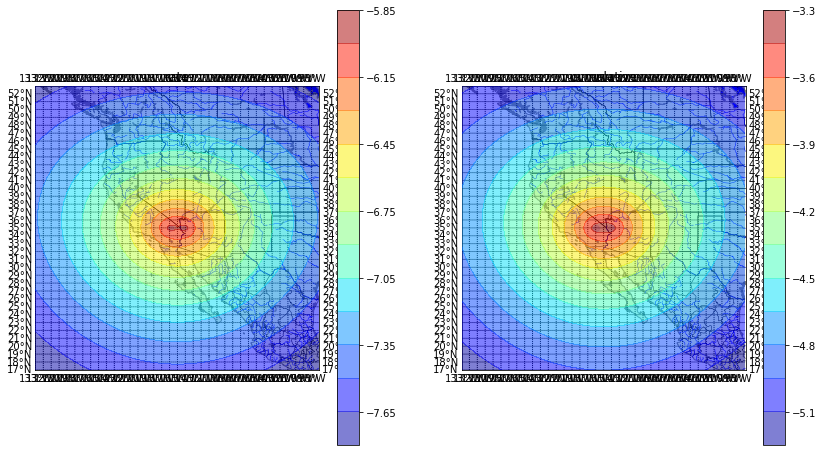

In [30]:
# test:
#
m0=7.
#dm=3.
lat0=35.
lon0=-115.
delta_t=2.
t0=dtm.datetime(2018,1,1, tzinfo=tzutc)
mc=3.
q_cat=1.5
#
cat = []
#
cat += [[t0, lon0-1., lat0, m0, mpd.date2num(t0) ]]
cat += [[t0, lon0+1., lat0, m0, mpd.date2num(t0) ]]

#
tms = t0
#
cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])
#
######################################
######################################
#
gep_cat = gep.make_ETAS_catalog_mpp(incat=cat.copy(), fit_factor=10.*210.*.5, mc=mc)
eqs = [gep.Earthquake(eq) for eq in gep_cat]

d_lat=1.5
d_lon=1.5
mylats = [lat0 - 12.*d_lat, lat0 + 12.*d_lat]
mylons = [lon0 - 12.*d_lon, lon0 + 12.*d_lon] 
ms_etas = gep.ETAS_mpp(catalog=gep_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon,
                       ab_ratio_max=2., t_now=t0, t_future=None, mc=mc, etas_range_factor=45.0,
                       q_cat=q_cat, dmstar=0.0, n_cpu=4)
ms_etas_cum = gep.ETAS_mpp(catalog=gep_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon,
                       ab_ratio_max=2., t_now=tms, t_future=tms+dtm.timedelta(days=30), 
                           mc=mc, etas_range_factor=45.0, q_cat=q_cat, dmstar=0.0, n_cpu=4)
#
#
fg = plt.figure(figsize=(14,8))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ms_etas.make_etas_contour_map(ax=ax1, lats_map=mylats, lons_map=mylons)
ms_etas_cum.make_etas_contour_map(ax=ax2, lats_map=mylats, lons_map=mylons)

#
ax1.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
ax2.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)

ax1.set_title('rate')
ax2.set_title('cumulative')

#
total_rate = numpy.sum(ms_etas.ETAS_array['z'])*121.
total_cum  = numpy.sum(ms_etas_cum.ETAS_array['z'])*121.
#
print('rate:  {}'.format(total_rate))
print('count: {}'.format(total_cum))
#
total_rate = numpy.sum(ms_etas.ETAS_array['z']*(lat2km*lat2km*ms_etas.d_lat*ms_etas.d_lon*numpy.cos(ms_etas.ETAS_array['y']*2.*math.pi/360.)))
total_cum  = numpy.sum(ms_etas_cum.ETAS_array['z']*(lat2km*lat2km*ms_etas.d_lat*ms_etas.d_lon*numpy.cos(ms_etas.ETAS_array['y']*2.*math.pi/360.)))
#
print('rate:  {}'.format(total_rate))
print('count: {}'.format(total_cum))
#
print('rate: {}'.format(ms_etas.total_rate()))
print('count: {}'.format(ms_etas_cum.total_rate()))

etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1050.0, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f02847f1390>), datetime.datetime(2018, 11, 26, 17, 35, 10, 461234, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-10-29 17:37:25.930428+00:00
fetch and process catalog for dates: [datetime.datetime(2008, 10, 29, 17, 37, 25, 930428, tzinfo=<UTC>), datetime.datetime(2018, 10, 27, 17, 37, 25, 930428, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 0.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.0, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2008, 10, 29, 

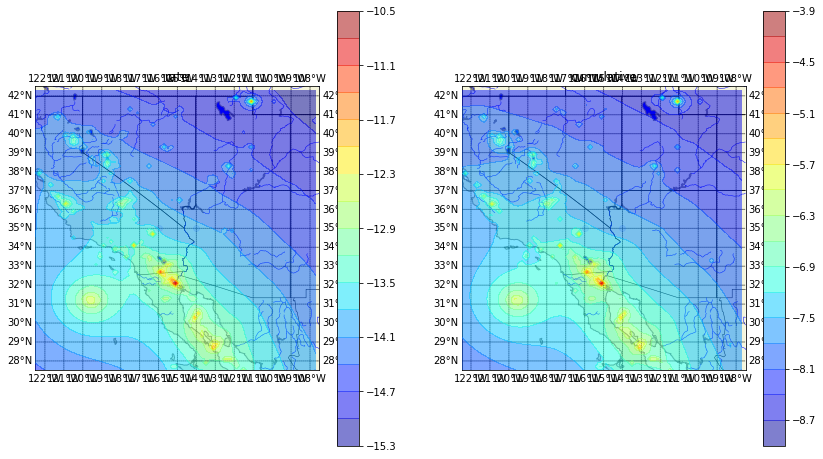

In [31]:
# test with real catalog:
#
m0=7.
#dm=3.
lat0    = 35.
lon0    = -115.
delta_t = 2.
t0 = dtm.datetime(2018,1,1, tzinfo=tzutc)
mc = 3.5
q_cat = 1.5
#
cat = []
#
cat += [[t0, lon0-1., lat0, m0, mpd.date2num(t0) ]]
cat += [[t0, lon0+1., lat0, m0, mpd.date2num(t0) ]]

#
tms = t0
#
cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])
#
######################################
######################################
#
gep_cat = gep.make_ETAS_catalog_mpp(incat=cat.copy(), fit_factor=1.0, mc=mc)
eqs = [gep.Earthquake(eq) for eq in gep_cat]

t1 = dtm.datetime.now(tzutc) - dtm.timedelta(days=30)
t2 = dtm.datetime.now(tzutc)

d_lat=1.5
d_lon=1.5
dl_fact=5.
mylats = [lat0 - dl_fact*d_lat, lat0 + dl_fact*d_lat]
mylons = [lon0 - dl_fact*d_lon, lon0 + dl_fact*d_lon] 
ms_etas = gep.ETAS_mpp(catalog=None, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon,
                       ab_ratio_max=2., t_now=t1, t_future=None, mc=mc, etas_range_factor=45.0, q_cat=q_cat,
                      d_lat=.2, d_lon=.2, dmstar=0.0, n_cpu=4)
ms_etas_cum = gep.ETAS_mpp(catalog=None, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon,
                       ab_ratio_max=2., t_now=t1, t_future=t2, 
                           mc=mc, etas_range_factor=45.0, q_cat=q_cat,
                      d_lat=.2, d_lon=.2, dmstar=0.0, n_cpu=4)
#
fg = plt.figure(figsize=(14,8))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ms_etas.make_etas_contour_map(ax=ax1, lats_map=mylats, lons_map=mylons)
ms_etas_cum.make_etas_contour_map(ax=ax2, lats_map=mylats, lons_map=mylons)

#
ax1.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
ax2.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)

ax1.set_title('rate')
ax2.set_title('cumulative')
#
total_rate = numpy.sum(ms_etas.ETAS_array['z']*(lat2km*lat2km*ms_etas.d_lat*ms_etas.d_lon*numpy.cos(ms_etas.ETAS_array['y']*2.*math.pi/360.)))
total_cum  = numpy.sum(ms_etas_cum.ETAS_array['z']*(lat2km*lat2km*ms_etas.d_lat*ms_etas.d_lon*numpy.cos(ms_etas.ETAS_array['y']*2.*math.pi/360.)))
#
print('rate:  {}'.format(total_rate))
print('count: {}'.format(total_cum))
#
print('rate: {}'.format(ms_etas.total_rate()))
print('count: {}'.format(ms_etas_cum.total_rate()))
#
mycat = atp.cat_from_comcat(lon=mylons, lat=mylats, minMag=mc,
                            dates0=[t1,t2], Nmax=None, fout=None, rec_array=True)
#
print('catalog_cum: ', len(mycat))
#

In [49]:
mycat = atp.cat_from_comcat(lon=mylons, lat=mylats, minMag=mc,
                           dates0=[t1,t2], Nmax=None, fout=None, rec_array=True)

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-28 17:37:25.930498+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 10], None)
make_etas():
etas_mpp worker xyz_range:  [0, 1406]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-28 17:37:25.930498+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 10], [0, 1406])
etas_mpp worker xyz_range:  [1406, 2812]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2008-11-28 17:37:25.930498+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 10], [1406, 2812])
etas_mpp worker xyz_range:  [2812, 4218]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now -

/home/myoder/Dropbox/Research/globalETAS/globalETAS.py:362: RuntimeWarning: divide by zero encountered in log10
  if Z is None: Z = numpy.log10(self.lattice_sites)


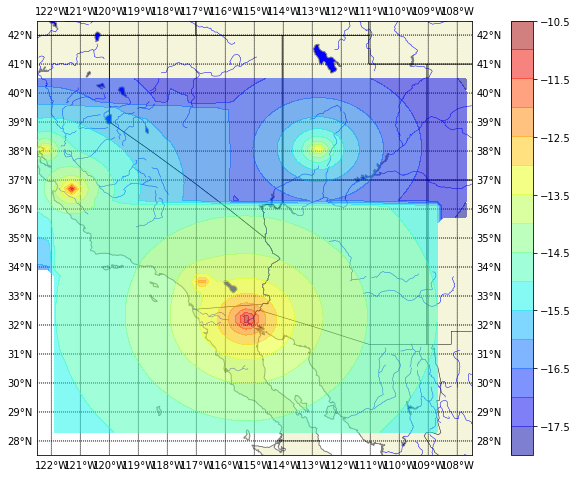

In [50]:
# now, get an ETAS of the test time, but set p_map = 0 (so thre is no Omori fade). i guess for now,
#  normalize this to N in the catalog. maybe later we should look at some other smoorhing algorithm.
#
# gep.make_ETAS_catalog_mpp(incat=cat.copy(), fit_factor=1.0, mc=mc)
#
#mycat = atp.cat_from_comcat(lon=mylons, lat=mylats, minMag=mc,
#                            dates0=[t1,t2], Nmax=None, fout=None, rec_array=True)
#

#mycat = gep.make_ETAS_catalog(incat=mycat.copy(), fit_factor=1.0, mc=mc)
#
ms_etas_test_cum  = gep.ETAS_mpp(catalog=gep.make_ETAS_catalog(incat=mycat.copy(), fit_factor=1.0, mc=mc), 
                                 lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon,
                       ab_ratio_max=2., t_0=t1, t_now=t2, 
                           mc=mc, etas_range_factor=50.0, etas_range_padding=2.0,  q_cat=q_cat,
                      d_lat=.2, d_lon=.2, dmstar=0.0, n_cpu=4)

fg = plt.figure(figsize=(14,8))
ax1 = plt.subplot('111')
#ax2 = plt.subplot('122')
ms_etas_test_cum.make_etas_contour_map(ax=ax1, lats_map=mylats, lons_map=mylons)


len:  10
2018-10-30T08:15:17.110000
2018-11-20T01:37:39.420000
z_total:  4.48947807727e-08
len_xyz:  5625 5625


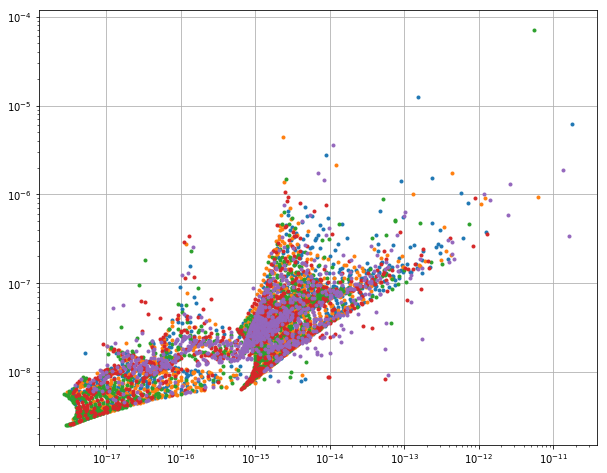

In [82]:
print('len: ', len(ms_etas_test_cum.catalog))
print(min(ms_etas_test_cum.catalog['event_date']))
print(max(ms_etas_test_cum.catalog['event_date']))
print('z_total: ', ms_etas_test_cum.total_rate())
#
print('len_xyz: ', len(ms_etas_test_cum.ETAS_array), len(ms_etas_cum.ETAS_array))
#
ix_0 = numpy.array([x is not None and x>0 for x in ms_etas_test_cum.ETAS_array['z']])
etas_cum = ms_etas_cum.ETAS_array[ix_0].copy()
etas_test = ms_etas_test_cum.ETAS_array[ix_0].copy()
etas_cum.sort(order=('x', 'y'))
etas_test.sort(order=('x', 'y'))
#
N = len(etas_test)
n_labels=5
seq_index_cum = numpy.argsort(etas_cum['z'])
seq_index_test = numpy.argsort(etas_test['z'])
#
cum_labels = numpy.array(seq_index_cum//(N/n_labels), dtype='<i8')
#print('*** **: ', cum_labels[1000:1100])
#
# quantiles_cum = seq_index_cum[seq_index_cum%(int(N/10))==0]
# quantiles_test = seq_index_test[seq_index_test%(int(N/10))==0]
# print('q_c: ', quantiles_cum)
# print('q_t: ', quantiles_test)
#

#
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
#
for k in range(n_labels):
    #if k<4: continue
    ax1.plot(etas_test['z'][cum_labels==k], etas_cum['z'][cum_labels==k], ls='', marker='.')
    
x_m = max(etas_test['z'])
y_m = max(etas_cum['z'])
ax1.plot([0,0,x_m], [y_m, 0, 0], ls='-', lw=2., alpha=.7, color='k')

#
# ax1.set_xlim(-1e-13, 2.5e-13)
# # #ax1.set_ylim(None, .00001)
# ax1.set_ylim(-.0000002, .000002)
ax1.grid()
#
ax1.set_xscale('log')
ax1.set_yscale('log')

In [17]:
# for eq in gep_cat:
#     print('** ', eq['t_0', 'tau'])
# print(gep_cat.dtype.names)

print(gep_cat[['t_0', 'tau', 'p']])

[(58.78580828305981, 0.006653846084070032, 1.1)
 (58.78580828305981, 0.006653846084070032, 1.1)]


In [18]:
for k,rw in enumerate(gep_cat):
    tau = rw['tau']
    t_0  = rw['t_0']
    p   = rw['p']
    print('omori: ', 1./(tau*(t_0**p)), ' *** ')
    # TODO: recompute for t1,t2? but i think t1 should acturally be t1=0...
    print('cum:   ', (1./(tau*(1.-p)))*( ((t_0 + 30*24.*3600)**(1.-p)) - (t_0**(1.-p))), ' *** ')

omori:  1.70109084013  *** 
cum:    656.787762374  *** 
omori:  1.70109084013  *** 
cum:    656.787762374  *** 


In [19]:
print('{}, {}, {}, {}'.format(ms_etas.t_now, ms_etas.t_0, ms_etas.t_future, ms_etas.t_forecast))
#
print('{}, {}, {}, {}'.format(ms_etas_cum.t_now, ms_etas_cum.t_0, ms_etas_cum.t_future, ms_etas_cum.t_forecast))


2018-01-01 00:00:00+00:00, 2008-01-04 00:00:00+00:00, None, 736695.0
2018-01-01 00:00:00+00:00, 2008-01-04 00:00:00+00:00, 736725.0, 736695.0


In [20]:
for eq in eqs:
    print('** ', eq.omori_rate(mpd.date2num(t0)))

**  1.70109084013
**  1.70109084013
